In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage
import copy

np.random.seed(2020)


In [2]:
# Read in Data
with open('data/sem_items_new.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations_new.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes_new.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])

In [3]:
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(*names_items,sep=',')
print("\nList of relations:")
print(*names_relations,sep=',')
print("\nList of attributes:")
print(*names_attributes,sep=',')

List of items:
Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile

List of relations:
ISA,Is,Can,Has

List of attributes:
Living thing,Plant,Animal,Tree,Flower,Bird,Fish,Reptile,Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile,Pretty,Big,Living,Green,Red,Yellow,Slow,Grow,Move,Swim,Fly,Sing,Skin,Roots,Leaves,Bark,Branch,Petals,Wings,Feathers,Gills,Scales,Backbone,Produce Eggs,Shell


In [4]:
item_display_ind = 35 # can change, just represents index of input data to show as example.

D = np.loadtxt('data/sem_data_new.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns



input_v = input_pats[item_display_ind,:].numpy().astype('bool')
output_v = output_pats[item_display_ind,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:nobj]])
print('Relation ',end='')
print(names_relations[input_v[nobj:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 1]

Which encodes...
Item ['Turtle']
Relation ['Has']
Attributes ['Skin' 'Backbone' 'Shell']


In [5]:
def plot_opt1(rep_layer) :
    
    stacked = np.dstack(rep_layer)
    fig,axes = plt.subplots(nrows=4,ncols=2,sharex=True,sharey=False,figsize=(15,10),squeeze=False)
    fig.suptitle('Representation Layer Weights per epoch',size=15)

    row_count,col_count = 0,0

    for j in range(8) :
        axes[row_count,col_count].set_title('Rep Node {}'.format(j))
        for i,name in enumerate(names_items) :
            axes[row_count,col_count].plot(range(n_epochs),stacked[i][j])
        if col_count == 1 :
            row_count+=1
            col_count = 0
        else :
            col_count += 1
    fig.legend(names_items,ncol=10,loc='lower center',fontsize=10)
    plt.show()

def plot_opt2(rep_layer) :
    
    stacked = np.dstack(rep_layer)
    fig,axes = plt.subplots(nrows=5,ncols=2,sharex=True,sharey=False,figsize=(15,10),squeeze=False)
    fig.suptitle('Representation Layer Weights per epoch',size=15)

    row_count,col_count = 0,0

    for i,name in enumerate(names_items) :
        axes[row_count,col_count].set_title(name)
        for j in range(8) :
            axes[row_count,col_count].plot(range(n_epochs),stacked[i][j])
        if col_count == 1 :
            row_count+=1
            col_count = 0
        else :
            col_count += 1
    fig.legend(['Rep_Node_'+str(i) for i in range(8)],ncol=10,loc='lower center',fontsize=10)
    plt.show()

def plot_opt3(rep_layer,num_plots=3):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    epochs_plot = [i if i < len(rep_layer) else i-1 for 
                   i in list(map(int,np.linspace(0,len(rep_layer),num_plots)))]
    stacked = np.dstack(rep_layer)    
    mx,mn = stacked.max(),stacked.min()
    count = 1
    plt.figure(1,figsize=(15,10))
    for i in range(nobj):
        for d in epochs_plot:
            plt.subplot(nobj, num_plots, count)
            rep = stacked[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names_items[i])
            if i==0:
                plt.title("epoch " + str(d))
            count += 1
    plt.show()
    
def plot_rep(plot_option,rep_layer,num_plots=3) :
    
    if plot_option==1 :
        plot_opt1(rep_layer)
    elif plot_option==2 :
        plot_opt2(rep_layer)
    elif plot_option==3:
        plot_opt3(rep_layer,num_plots)
    else:
        raise ValueError('Invalid option #')

def plot_dendo(rep_layer,num_plots=3):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    epochs_plot = [i if i < len(rep_layer) else i-1 for 
                   i in list(map(int,np.linspace(0,len(rep_layer),num_plots)))]
    
    mx = linkage(rep_layer[-1],'single')[:,2].max()+.1
    plt.figure(num_plots,figsize=(5,10))
    for i,d in enumerate(epochs_plot) :
        linked = linkage(rep_layer[d],'single')
        plt.subplot(num_plots,1,i+1)
        plt.tight_layout()
        dendrogram(linked, labels=names_items, color_threshold=0)
        plt.ylim([0,mx])
        plt.yticks(fontsize=12)
        if i == 0 :
            plt.title("Dendrogram Relationships per epoch \nepoch " + str(d))
        else :
            plt.title("epoch " + str(d))
        plt.xticks(rotation=45,ha='right')
    plt.show()
    
def plot_loss(err) :
    
    plt.figure(figsize=(10,5))
    plt.plot(range(n_epochs),err)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Epoch #',fontsize=15)
    plt.ylabel('Loss',fontsize=15)
    plt.title('Loss per Epoch',fontsize=20)
    plt.show()
    
## The following observes principal components for the representation layer drawn out at different points in
## time of training. Essentially a multi-variate visualization to seeing differentiation through training.

def plot_pca(rep_layer, names_items,num_time_points):
    inds_look = np.linspace(0,len(rep_layers),num_time_points)
    inds_look[-1] = inds_look[-1]-1
    inds_look = list(map(int,inds_look))

    projections = []

    for ind in inds_look:
        mat = rep_layer[ind]
        u,s,v = np.linalg.svd(mat.T.dot(mat))
        projection = mat.dot(v[:,:2])
        print('2 PCs explain {}% of variance'.format(round(100*(np.cumsum(s) / np.sum(s))[1],ndigits=2)))
        projections.append(projection)

    plt.figure(figsize=(20,10))
    for i in range(len(names_items)) :
        to_plot = np.array(projections)[:,i]
        plt.plot(to_plot[:,0],to_plot[:,1])
        plt.annotate(names_items[i],(to_plot[-1,0],to_plot[-1,1]))
    plt.title('Principal Component Analysis of Representation Layer',fontsize=20)
    plt.xlabel('First Principal Component',fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('Second Principal Component',fontsize=15)
    plt.show()
    
def Species_Epoch(species,output_layers) :
    
    if species not in names_items :
        raise ValueError('Invalid species name')
    
    ind_species = np.where(names_items == species)[0]
    input_inds = np.where(input_pats[:,ind_species] == 1)[0]

    characteristics = {val:{} for val in names_relations}
    for n in range(len(output_layers)) :
        for i,v in enumerate(names_relations) :
            input_species = input_pats[input_inds[i]]
            output_species = output_layers[n][input_inds[i]]
            true_output = output_pats[input_inds[i]]

            rels_look = names_attributes[true_output.detach().numpy().astype('bool')]

            for j,item in enumerate(rels_look) :
                if item in characteristics[v] :
                    characteristics[v][item].append(output_species[true_output.detach().numpy().astype('bool')][j])
                else :
                    characteristics[v][item] = [output_species[true_output.detach().numpy().astype('bool')][j]]
                    
    return characteristics

def plot_epoch_per_species(fnc_create_data,species,output_layers) :
    
    char_out = fnc_create_data(species,output_layers)
    
    fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10),sharex=True,sharey=True)
    row,col = 0,0
    for key in char_out.keys() :
        for k,v in char_out[key].items() :
            axes[row][col].plot(list(range(len(output_layers)))[30:],v[30:],label = key+"_"+k)
        axes[row][col].legend()
        axes[row][col].set_xlabel('Epoch',fontsize=15)
        axes[row][col].set_ylabel('Activation',fontsize=15)
        axes[row][col].tick_params('both',labelsize=15)
        axes[row][col].set_title(species+' '+key,fontsize=20)
        if row == 1 :
            row -= 1
            col += 1
        else :
            row += 1

In [6]:
def apply_gaussian_noise(net,scale) :
    
    model = copy.deepcopy(net) #otherwise actual model might change in place.
    model.eval()
    new_weights = model.state_dict()

    
    # add mutlivariate random matrix element-wise to weights.
    noisy_add = np.random.normal(loc=0,scale=scale,
                                 size=new_weights['i2rep.weight'].size())
    
    new_weights['i2rep.weight'] += noisy_add
    model.load_state_dict(new_weights)
    
    return model

def apply_dropout_noise(net,probability) :
    
    model = copy.deepcopy(net) #otherwise actual model might change in place.
    model.eval()
    new_weights = model.state_dict()

    dim1,dim2 = new_weights['i2rep.weight'].size()
    
    rand_use = np.random.random(size=dim1) > probability
    weights_new = (rand_use.astype(int)).reshape(dim1,1) * new_weights['i2rep.weight'].detach().numpy()
    
    new_weights['i2rep.weight'] = torch.tensor(weights_new)
    model.load_state_dict(new_weights)
    
    return model

def Categorize_Outputs(net,general_names,intermediate_names,specific_names,relation_eval='ISA') :
    
    ind_relation = np.where(names_relations == relation_eval)[0][0]

    patterns_eval = input_pats[ind_relation::len(names_relations)]
    patterns_truth = output_pats[ind_relation::len(names_relations)]
    general_out = []
    intermediate_out = []
    specific_out = []
    negative_out = []

    for i,pattern in enumerate(patterns_eval) :
        true_output_bool = patterns_truth[i].detach().numpy().astype('bool')
        names_eval = names_attributes[true_output_bool]
        mod_output = net(pattern)[0].detach().numpy()[0][true_output_bool]  
        for j,name in enumerate(names_eval) :
            if name in general_names :
                general_out.append(mod_output[j])
            if name in intermediate_names :
                intermediate_out.append(mod_output[j])
            if name in specific_names :
                specific_out.append(mod_output[j])
                
    inds_truth = np.argwhere(patterns_truth.detach().numpy())
    inds_false = np.argwhere(patterns_truth.detach().numpy() == 0)

    inds_false = inds_false[np.isin(inds_false[:,1],list(set(inds_truth[:,1])))]
    negative_outputs = net(patterns_eval)[0].detach().numpy()[inds_false[:,0],inds_false[:,1]]
                
    return np.mean(general_out),np.mean(intermediate_out),np.mean(specific_out),np.mean(negative_outputs)

def Noise_Degredation(net,scales,num_run,fnc_noise,fnc_categorize,general_names,
                      intermediate_names,specific_names,relation_eval='ISA') :
    
    noise_stats = {item:{scale:[] for scale in scales} for 
                   item in ['general','intermediate','specific','negative']}

    for scale in scales :
        for _ in range(num_run) :
            model = fnc_noise(net,scale)
            g_out,int_out,s_out,neg_out = fnc_categorize(model,general_names,intermediate_names,
                                                 specific_names,relation_eval)
            
            noise_stats['general'][scale].append(g_out)
            noise_stats['intermediate'][scale].append(int_out)
            noise_stats['specific'][scale].append(s_out)
            noise_stats['negative'][scale].append(neg_out)
            
    return noise_stats

In [7]:
class Net(nn.Module):
    def __init__(self, n_items, n_relations, n_attributes, rep_layer_size, hidden_layer_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        self.n_items = n_items # input to rep
        self.n_relations = n_relations # input to hidden
        self.n_attributes = n_attributes # output        
        
        self.i2rep = nn.Linear(self.n_items, rep_layer_size,bias=False)
        self.all2h = nn.Linear(rep_layer_size+self.n_relations, hidden_layer_size,bias=False)
        self.h2o   = nn.Linear(hidden_layer_size, self.n_attributes,bias=False)
        
        # initialize untrainable bias.
        #self.i2rep.bias = nn.Parameter(torch.ones(1,self.n_items),requires_grad=False)
        self.all2h.bias = nn.Parameter(torch.ones(1,hidden_layer_size),requires_grad=True)
        self.h2o.bias = nn.Parameter(torch.ones(1,self.n_attributes),requires_grad=True)
        
        # initialize weights.
        #nn.init.uniform_(self.i2rep.weight,-1.643,1.643)
        #nn.init.uniform_(self.all2h.weight,-1.643,1.643)
        #nn.init.uniform_(self.h2o.weight,-1.643,1.643)
                
    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x      = x.view(-1, self.n_items+self.n_relations) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:self.n_items] # input to Item Layer [B x nobj Tensor]
        x_rel  = x[:,self.n_items:] # input to Relation Layer [B x nrel Tensor]

        rep             = relu(self.i2rep(x_item))
        input_to_hidden = torch.cat((rep,x_rel), dim=1)
        hidden          = relu(self.all2h(input_to_hidden))
        output          = torch.sigmoid(self.h2o(hidden))
                
        return output, hidden, rep

In [8]:
loaded_model = torch.load('trained_model_SGD_BCELoss_0.05_3500_2_20200512125214.pt')

print(*loaded_model['model_state_dict'].keys(),sep=',')

i2rep.weight,all2h.weight,all2h.bias,h2o.weight,h2o.bias


In [9]:
mynet = Net(nobj,nrel, nattributes,rep_layer_size=loaded_model['model_state_dict']['i2rep.weight'].size()[0],
            hidden_layer_size=loaded_model['model_state_dict']['all2h.weight'].size()[0])

mynet.load_state_dict(loaded_model['model_state_dict'])

<All keys matched successfully>

In [10]:
rep_layers = loaded_model['rep_layer']
loss = loaded_model['losses']
n_epochs = loaded_model['epoch']
output_layers = loaded_model['out_layer']

# Training / Differentiation

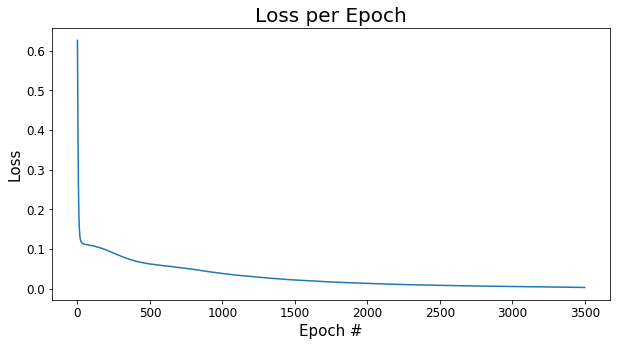

In [11]:
plot_loss(loss)

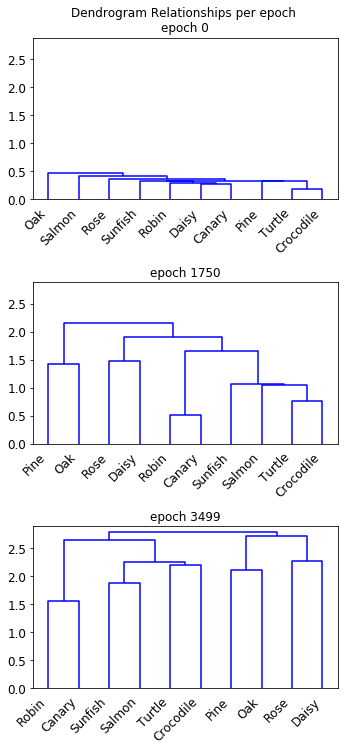

In [12]:
plot_dendo(rep_layers)

2 PCs explain 65.71% of variance
2 PCs explain 74.56% of variance
2 PCs explain 57.87% of variance
2 PCs explain 52.55% of variance


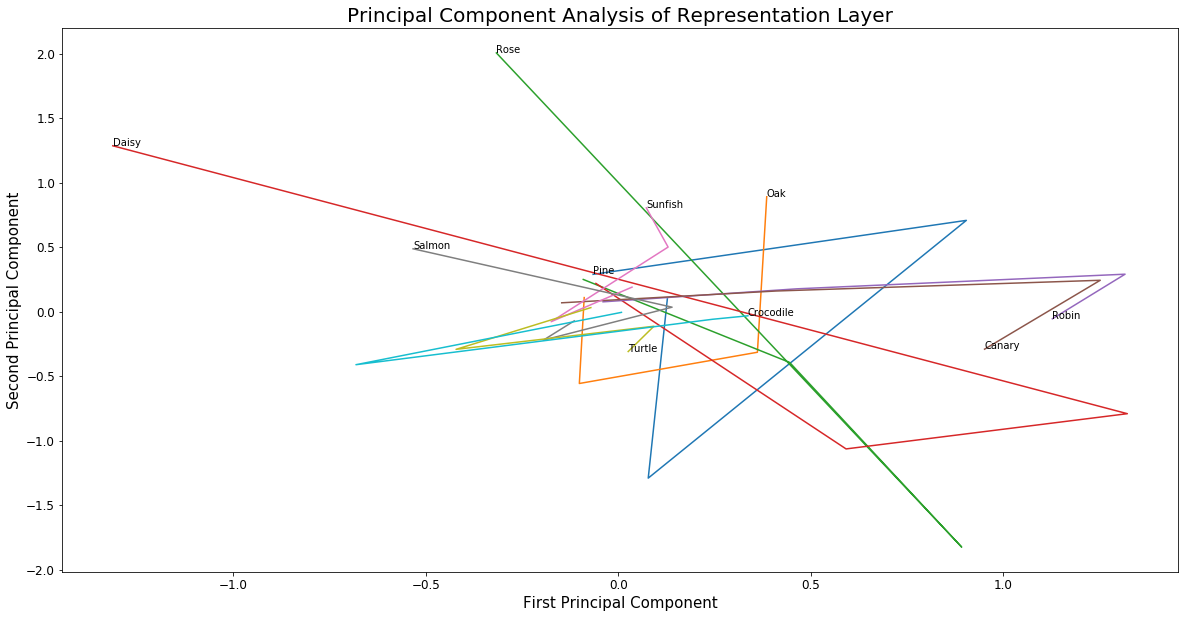

In [13]:
plot_pca(rep_layers, names_items,4)

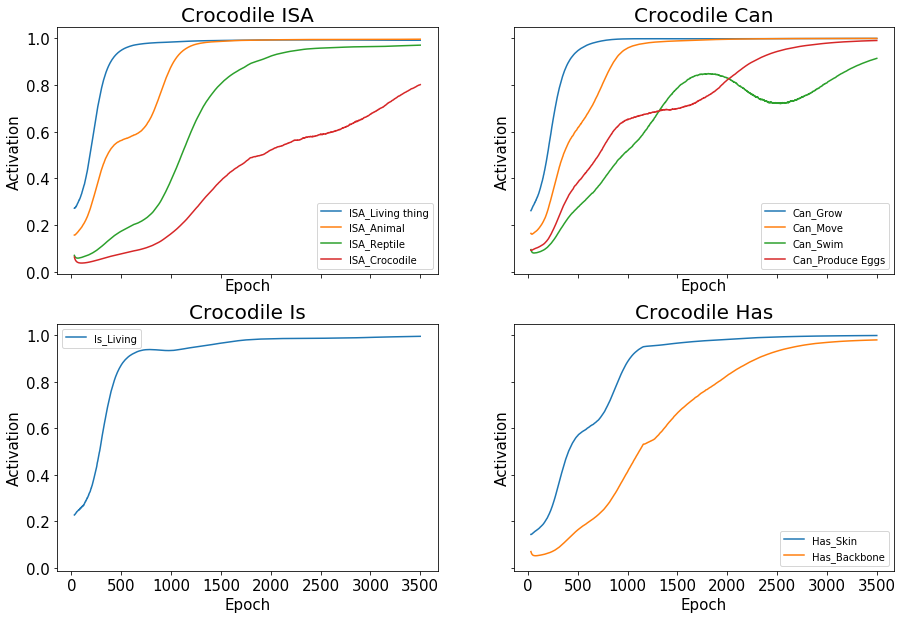

In [14]:
plot_epoch_per_species(Species_Epoch,'Crocodile',output_layers)

# Noise

In [15]:
general = names_attributes[1:3]
intermediate = names_attributes[3:8]
specific = names_attributes[8:]


relation_eval = 'ISA'
scales_use = np.linspace(0,2,10)

ind_relation = np.where(names_relations == relation_eval)[0][0]
patterns_eval = input_pats[ind_relation::len(names_relations)]
patterns_truth = output_pats[ind_relation::len(names_relations)]

noisy_outputs = Noise_Degredation(mynet,scales_use,50,
                                  apply_gaussian_noise,Categorize_Outputs,
                                  general,intermediate,specific,relation_eval)

noise_formatted = {} 
for k,v in noisy_outputs.items() :
    noise_formatted[k] = {}
    for scale,vals in v.items() :
        noise_formatted[k][scale] = {}
        noise_formatted[k][scale]['mean'] = np.mean(vals,axis=0)
        noise_formatted[k][scale]['std'] = np.std(vals,axis=0)

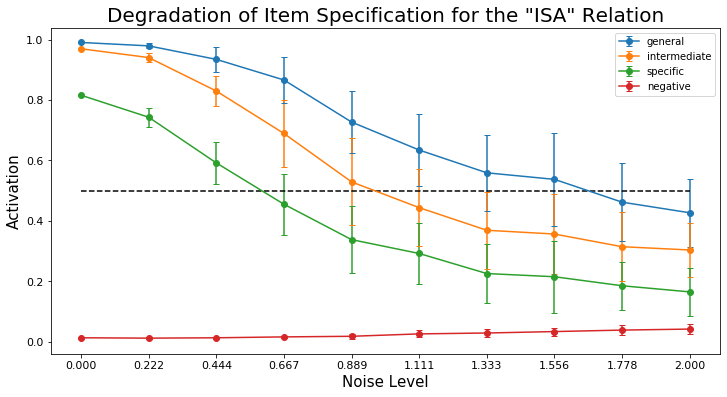

In [16]:
plt.figure(figsize=(12,6))
for k,v in noise_formatted.items() :
    to_plot = [v[scale]['mean'] for scale in v.keys()]
    to_plot_error = [v[scale]['std'] for scale in v.keys()]
    plt.errorbar(scales_use,to_plot,yerr=to_plot_error,label=k,linestye=None,marker='o',capsize=3)
plt.hlines(y=.5,xmin=0,xmax=max(scales_use),linestyle='--')
plt.legend()
plt.xticks(scales_use,fontsize=11)
plt.yticks(fontsize=11)
plt.title('Degradation of Item Specification for the "{}" Relation'.format(relation_eval),fontsize=20)
plt.xlabel('Noise Level',fontsize=15)
plt.ylabel('Activation',fontsize=15)
plt.show()

In [17]:
probabilities_use = np.linspace(0,1,10)
relation_eval= 'ISA'

noisy_outputs = Noise_Degredation(mynet,probabilities_use,50,
                                  apply_dropout_noise,Categorize_Outputs,
                                  general,intermediate,specific,relation_eval)

noise_formatted = {} 
for k,v in noisy_outputs.items() :
    noise_formatted[k] = {}
    for scale,vals in v.items() :
        noise_formatted[k][scale] = {}
        noise_formatted[k][scale]['mean'] = np.mean(vals,axis=0)
        noise_formatted[k][scale]['std'] = np.std(vals,axis=0)

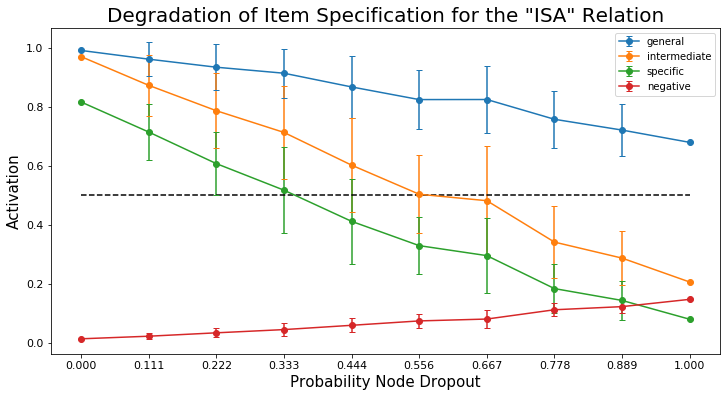

In [18]:
plt.figure(figsize=(12,6))
for k,v in noise_formatted.items() :
    to_plot = [v[scale]['mean'] for scale in v.keys()]
    to_plot_error = [v[scale]['std'] for scale in v.keys()]
    plt.errorbar(probabilities_use,to_plot,yerr=to_plot_error,label=k,linestye=None,marker='o',capsize=3)
plt.hlines(y=.5,xmin=0,xmax=max(probabilities_use),linestyle='--')
plt.legend()
plt.xticks(probabilities_use,fontsize=11)
plt.yticks(fontsize=11)
plt.title('Degradation of Item Specification for the "{}" Relation'.format(relation_eval),fontsize=20)
plt.xlabel('Probability Node Dropout',fontsize=15)
plt.ylabel('Activation',fontsize=15)
plt.show()